# Load training and testing data

In [28]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

train_data = pd.read_csv('adult.train.csv')
test_data = pd.read_csv('adult.test.csv')

# Preprocessing

In [29]:
def preprocess_data(data):
    data['income'] = data['income'].apply(lambda x: 0 if x == ' <=50K' else 1)
    data.drop('education', axis=1, inplace=True)
    data.replace(" ?", pd.NA, inplace=True)
    data.dropna(inplace=True)
    return data

# Apply preprocessing to training and testing data
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# label encoding
label_encoders = {}

# Initialize categorical columns
categorical_columns = ['workclass', 'relationship', 'native-country',
                       'marital-status','occupation', 'race', 'sex']

for col in categorical_columns:
    # Create a LabelEncoder for the column
    le = LabelEncoder()
    # Fit on the training data
    train_data[col] = le.fit_transform(train_data[col])
    # Transform the test data using the trained encoder
    test_data[col] = le.transform(test_data[col])
    # Store the encoder in the dictionary
    label_encoders[col] = le

# Separate the features and the target variable

In [30]:

X_train = train_data.drop('income', axis=1)
y_train = train_data['income']
X_test = test_data.drop('income', axis=1)
y_test = test_data['income']

# Visualization

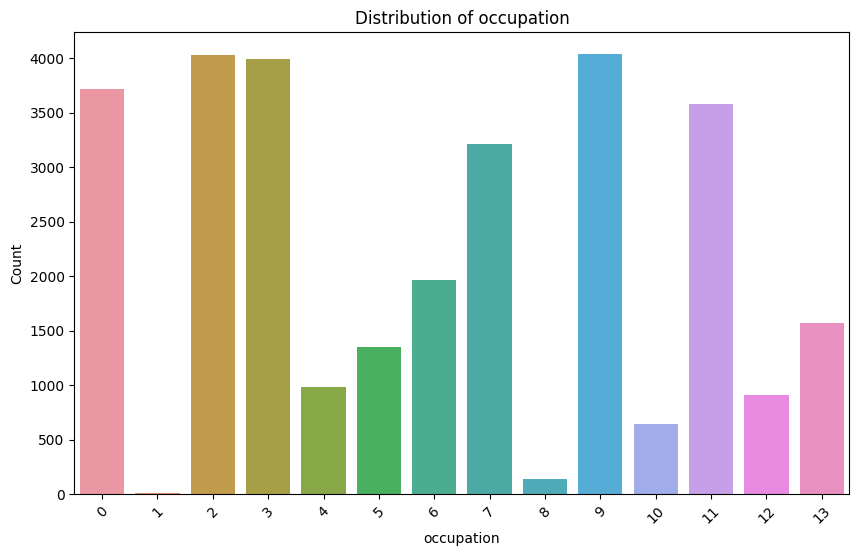

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

column_name = 'occupation'

# Count the frequency of each category in the column
category_counts = train_data[column_name].value_counts()


plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title(f'Distribution of {column_name}')
plt.xlabel(column_name)
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed for readability
plt.show()


In [32]:
# we can see class imbalance here
train_data['income'].value_counts()

0    22654
1     7508
Name: income, dtype: int64

# Fitting and evaluating the model


In [33]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

# Out-of-bag accuracy

In [34]:
from sklearn.metrics import accuracy_score

# Predict on the test set
preds = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, preds)
print(f'Out-of-bag accuracy score = {accuracy:.3f}')


Out-of-bag accuracy score = 0.850


# Seach for hyperparameters

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [ 'sqrt', 'log2', None],
    'bootstrap': [True, False]
}


# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a5f35440640>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a5f35443430>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a5f354407f0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a5f354434f0>})

# Best hyperparameters

In [36]:
# variable for the best model
best_rf = rand_search.best_estimator_

# best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 15, 'n_estimators': 344}


# RandomForest with the best hyperparameters

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



best_rf = RandomForestClassifier(**rand_search.best_params_,random_state=42)

# Fit the model on the training data
best_rf.fit(X_train, y_train)

# Predict on the test set
preds = best_rf.predict(X_test)


accuracy = accuracy_score(y_test, preds)
print(f'Accuracy score = {accuracy:.3f}')


Accuracy score = 0.860


# Confusion Matrix

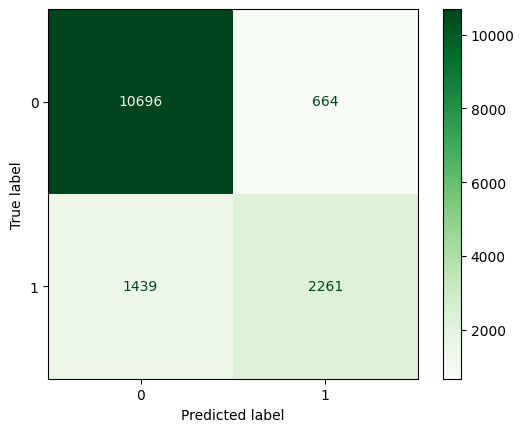

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Greens')

plt.show()


# Accuracy, precision, recall

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8603585657370518
Precision: 0.772991452991453
Recall: 0.6110810810810811
